# Data handling and processing

**Installing and importing dependencies**

In [95]:
!pip install torchinfo

In [96]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torchinfo import summary
from skimage import io

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import cv2

import os

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Preparing data**

In [98]:
image_dirs=['/kaggle/input/wikiart-art-movementsstyles/Rococo/Rococo',
           '/kaggle/input/wikiart-art-movementsstyles/Expressionism/Expressionism']
dir2img = {d: i for i, d in enumerate(image_dirs)}
dir2img = {d: i for i, d in dir2img.items()}

print(dir2img)

{0: '/kaggle/input/wikiart-art-movementsstyles/Rococo/Rococo', 1: '/kaggle/input/wikiart-art-movementsstyles/Expressionism/Expressionism'}


In [99]:
class LoadImgData():
    """ Load data from each dir as np arr and save loaded dataset."""
    def __init__(self):
        self.roc = image_dirs[0]
        self.exp = image_dirs[1]
        self.labels = {self.roc: np.eye(2, 2)[0], self.exp: np.eye(2, 2)[1]}
        self.dataset = []
        self.roc_count = 0
        self.exp_count = 0

    def create_dataset(self):
        """Read image paths from dir and save them with labels."""
        for key in self.labels:
          print(key)
          for img_file in tqdm(os.listdir(key)):
            try:
              path = os.path.join(key, img_file)
              
              self.dataset.append([path, self.labels[key]])
              
              if key == self.roc:
                self.roc_count+=1
              elif key == self.exp:
                self.exp_count+=1

            except Exception as e:
              pass
     
#         np.random.shuffle(self.dataset)
    
        print(f'\n rococco art images: {self.roc_count}')
        print(f'expressionism art images: {self.exp_count}')
        print(f'total: {self.roc_count + self.exp_count}')
        return np.array(self.dataset, dtype='object')
    
    #save path,label

In [100]:
img_data = LoadImgData()
dataset = img_data.create_dataset()

/kaggle/input/wikiart-art-movementsstyles/Rococo/Rococo


  0%|          | 0/2521 [00:00<?, ?it/s]

/kaggle/input/wikiart-art-movementsstyles/Expressionism/Expressionism


  0%|          | 0/2607 [00:00<?, ?it/s]


 rococco art images: 2521
expressionism art images: 2607
total: 5128


In [101]:
class ArtDataset(Dataset):
    def __init__(self, custom_dataset, transform=None):
        
        self.custom_dataset = custom_dataset
        self.transform= transform

    def __len__(self):
        return len(self.custom_dataset)
    
    def __getitem__(self, idx):
        image_path = self.custom_dataset[idx][0]
        image = cv2.imread(image_path)
        label = torch.tensor(self.custom_dataset[idx][1])
        if self.transform:
          image = self.transform(image)
        return (image, label)
    #take loadimgdata samples dataset arr, index idx row, you get path, label. read 
    

In [102]:
mean, std=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
img_size=224
data_transforms=T.Compose([T.ToTensor(), T.Resize((img_size, img_size)), T.Normalize(mean, std)])


In [103]:
dataset = ArtDataset(dataset, transform=data_transforms)

In [104]:
train_set_size = int(len(dataset) * 0.75)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size])

In [105]:
len(train_set)

3846

In [106]:
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=32)
valid_dataloader = DataLoader(valid_set, shuffle=True, batch_size=32)

In [107]:
len(train_dataloader)

121

In [108]:
class SaveBestModel:
    """ class to save best model while training. """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, loss_fn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/best_model.pth')

In [109]:
def save_model(epochs, model, optimizer, loss_fn):
    """
    save final model
    """
    print(f"Saving final model.")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/final_model.pth')

In [110]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plot to disk.
    """
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='green', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='valid loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/kaggle/working/loss.png')

**Plotting out image.** 

In [111]:
def denorm(tensor, mean=0.5, std=0.5):
    output=std*tensor+mean
    return torch.clamp(output, 0,1)

In [112]:
image_batch, label_batch=next(iter(train_dataloader))
image, label = image_batch[0] , label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor([1., 0.], dtype=torch.float64))

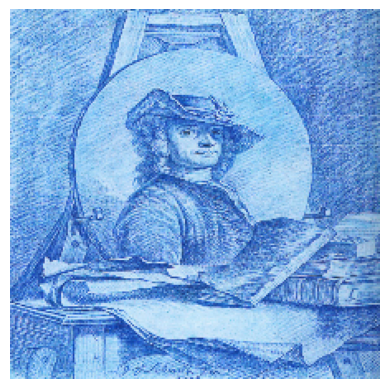

In [113]:
plt.imshow(denorm(image.permute(1, 2, 0)))
plt.axis(False);

------------------------------------

# Patch Embedding

In [114]:
class PatchEmbedding(nn.Module):
    
    '''
    Takes a 2-D image, turns it into a 1D sequence learnable embedding and then adds BERT cls token and positional encoding..
    
    Args:
        img_size (int) : image size 
        in_channels(int): number of color channels (C) default:3
        patch_size(int): side of sq patch
        embedding_dim: (N x (P^2 . C))
    ''' 
    
    def __init__(self, img_size:int=224, in_channels:int=3, 
                 patch_size:int=16,
                embedding_dim:int=768):
        super().__init__()
        
        self.patch_size=patch_size
        
        #conv layer to turn images into patches
        self.patcher=nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dim,
                               kernel_size=patch_size,
                               stride=patch_size,
                               padding=0)
        
        #flatten layer to flatten patch feature maps into a single dimension
        self.flatten=nn.Flatten(start_dim=2,
                               end_dim=3)
        
        #BERT 'cls' token (learnable)
        self.cls=nn.Parameter(torch.randn(1, 1, embedding_dim), 
                        requires_grad=True)
        
        #positional encoding
        number_of_patches=int((img_size/patch_size**2))
        self.position=nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dim), 
                               requires_grad=True)
        
    def forward(self, x):
        img_resolution=x.shape[-1]
#         assert img_resolution % patch_size==0, f"Input img size should be divisible by patch size for proper patching execution."
        
        x_patched=self.patcher(x)
        x_flattened=self.flatten(x_patched).permute(0,2,1)
        batch_size=x_flattened.size(0)
        cls_token = self.cls.expand((batch_size, -1, -1)) #broadcasting reasons
        x_tok=torch.cat((cls_token, x_flattened), dim=1)
        x_pos=self.position+x_tok
        return x_pos

In [115]:
patchify = PatchEmbedding(img_size=224, in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 197, 768])


In [116]:

random_input_image = (1, 3, 224, 224)

summary(PatchEmbedding(img_size=224), 
        input_size=(random_input_image),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 197, 768]        1,536                True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 592,128
Trainable params: 592,128
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

----------------------------

# Transformer utilities

In [117]:
dropout=0.1
num_classes=2

In [118]:
class MSAblock(nn.Module):
    
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout=dropout):
        super().__init__()
        
        self.ln=nn.LayerNorm(normalized_shape=embedding_dim)
        self.msa=nn.MultiheadAttention(embed_dim=embedding_dim,
                                      num_heads=num_heads,
                                      dropout=dropout,
                                      batch_first=True)
        
    def forward(self, x):
        x=self.ln(x)
        attn_output, _ = self.msa(query=x,
                                 key=x,
                                 value=x,
                                 need_weights=False)
        return attn_output

In [119]:
msa_b=MSAblock(embedding_dim=768, num_heads=12)

img_post_msa=msa_b(patch_embedded_image)
print(patch_embedded_image.shape)
print(img_post_msa.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [120]:
class MLPblock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072,
                dropout=dropout):
        super().__init__()
        
        self.ln=nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp=nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                 out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                 out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        x=self.ln(x)
        x=self.mlp(x)
        return x

In [121]:
class Classifier(nn.Module):
    def __init__(self, 
                embedding_dim:int=768,
                num_classes=num_classes):
        super().__init__()
        self.ln=nn.LayerNorm(normalized_shape=embedding_dim)
        self.linear=nn.Linear(in_features=embedding_dim,
                             out_features=num_classes)
        
    def forward(self,x):
        x=self.ln(x)
        x=self.linear(x)
        
        return x
        

In [122]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, 
                embedding_dim:int=768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout=dropout,
                attn_dropout=dropout):
        super().__init__()
        
        self.msa_block=MSAblock(embedding_dim=embedding_dim,
                num_heads=num_heads,
                attn_dropout=dropout)
        
        self.mlp_block=MLPblock(embedding_dim=embedding_dim,
                mlp_size=mlp_size,
                dropout=dropout)
        
    def forward(self, x):
        
        x=self.msa_block(x)+x
        x=self.mlp_block(x)+x
        
        return x
    

In [123]:
transformer_encoder_block=TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MSAblock (msa_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MLPblock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

--------------------------------------------

# Vision Transformer Architecture

In [124]:
class VIT(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                in_channels:int=3,
                img_size:int=224,
                patch_size:int=16,
                num_transformer_layers:int=12,
                mlp_size:int=3072,
                num_heads:int=12,
                attn_dropout=dropout,
                mlp_dropout=dropout,
                embedding_dropout=dropout,
                 num_classes:int=1000):
        
        super().__init__()
        
        assert img_size % patch_size == 0, f"Img size must be divisible by patch size. img size: {img_size}, patch size: {patch_size}."
        
        self.num_patches=(img_size * img_size) // patch_size**2
        
        self.embedding_dropout=nn.Dropout(p=embedding_dropout)
        self.patch_embedding=PatchEmbedding(in_channels=in_channels,
                                           patch_size=patch_size,
                                           embedding_dim=embedding_dim)
        self.trans_enc=nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                              num_heads=num_heads,
                                                              mlp_size=mlp_size,
                                                              mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier=Classifier(embedding_dim=embedding_dim,
                                   num_classes=num_classes
                                  )
    def forward(self, x):
        
        batch_size=x.shape[0]
        x=self.patch_embedding(x)
        x=self.embedding_dropout(x)
        x=self.trans_enc(x)
        x=self.classifier(x[:,0])
        
        return x
        
        

In [125]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [126]:
torch.manual_seed(42)
random_image_tensor = torch.randn(1, 3, 224, 224) # BCHW

vit = VIT(num_classes=num_classes)
vit(random_image_tensor)

tensor([[ 0.7729, -0.0980]], grad_fn=<AddmmBackward0>)

In [127]:

summary(model=vit, 
        input_size=(32, 3, 224, 224), #BCHW
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                     [32, 3, 224, 224]    [32, 2]              --                   True
├─PatchEmbedding (patch_embedding)            [32, 3, 224, 224]    [32, 197, 768]       1,536                True
│    └─Conv2d (patcher)                       [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                      [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                 [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (trans_enc)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)            [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MSAblock (msa_block)              [32, 197, 768]       [32, 197, 768]      

---------------------------

# Training the model

In [128]:
optimizer=torch.optim.Adam(params=vit.parameters(),
                          lr=3e-3,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

loss_fn=torch.nn.CrossEntropyLoss()
save_best_model=SaveBestModel()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [136]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss, train_acc=0,0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred=model(X)
        loss=loss_fn(y_pred, y)
        train_loss+=loss.item()
        train_loss += loss.detach().cpu().item() / len(dataloader)
        loss.backward()
        optimizer.step()

    train_loss=train_loss/len(dataloader)

    return train_loss
  

In [137]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    model.eval()
    test_loss, test_acc =0,0

    
    with torch.inference_mode():
        for batch, (X,y) in  enumerate(dataloader):
            X,y=X.to(device), y.to(device)
            test_pred_logits=model(X)
            loss=loss_fn(test_pred_logits, y)
            test_loss+=loss.item()
            
     
        test_loss = test_loss / len(dataloader)
        return test_loss

In [138]:
save_best_model=SaveBestModel()

In [139]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          device: torch.device,
         epochs: int):

        results = {"train_loss": [],
                   "test_loss": []
                  }
        train_epoch_loss=[]
        test_epoch_loss=[]
        
        model.to(device)
        for epoch in range(epochs):
                train_loss = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
                test_loss= test_step(model=model,
                  dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  device=device)
                
                print(
                      f"Epoch: {epoch+1} | "
                      f"train_loss: {train_loss:.4f} | "
                      f"test_loss: {test_loss:.4f} | "
                    )

                    # Update results dictionary
                results["train_loss"].append(train_loss)
                results["test_loss"].append(test_loss)
                train_epoch_loss.append(train_loss)
                test_epoch_loss.append(test_loss)
                save_best_model(test_loss, epoch, model, optimizer, loss_fn)
        
        save_model(epochs, model,optimizer, loss_fn)
        save_plots(train_epoch_loss, test_epoch_loss)
                

        return results

In [140]:
len(train_dataloader)

121

In [134]:
# count=0
# for i , (x, y) in enumerate(train_dataloader):
#     count=count+1
#     print({len(x), count})
    
    
    
    #error generated in this step if corrupt files in dataset.

Epoch: 1 | train_loss: 0.7054 | test_loss: 0.6997 | 

Saving best model for epoch: 1

Epoch: 2 | train_loss: 0.7035 | test_loss: 0.6933 | 

Saving best model for epoch: 2

Saving final model.


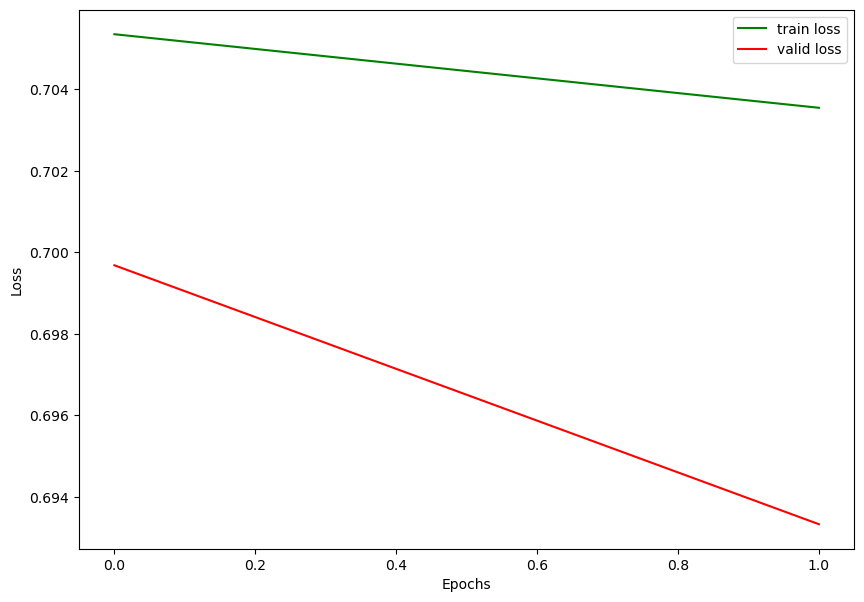

In [142]:
results=train(model=vit,
              train_dataloader=train_dataloader,
              test_dataloader=valid_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=2,
              device=device )